In [25]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import torch.nn.functional as F
loss_func = torch.nn.MSELoss()

In [26]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.0)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 3 * 8
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)
        

    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        
        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [28]:
model = aspect_augumentation(5128, 1154, 3, 32).to(DEVICE)
load_params = torch.load(
    'models/model_0.01_32_1e-06_[256].pkl')
model_params = model.state_dict()
same_parsms = {k: v for k, v in load_params.items()
               if k in model_params.keys()}
model_params.update(same_parsms)

model.load_state_dict(model_params)




<All keys matched successfully>

In [29]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
def traite_train_test(df):
    df['actors'] = df['actors'].apply(lambda x: json.loads(x))
    df['director'] = df['director'].apply(lambda x: json.loads(x))
    df['genre'] = df['genre'].apply(lambda x: json.loads(x))
    return df
trainset = traite_train_test(trainset)
testset = traite_train_test(testset)

In [30]:
def RMSE1(data, model):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)
    rmse = loss_func(prediction, rating)
    return rmse,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm


In [31]:
rate = 0.0
rmse,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = RMSE1(testset,model)

In [32]:
test = testset.copy()
index_user = test.drop_duplicates(subset = ['user_id'],keep = 'first').index.values

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

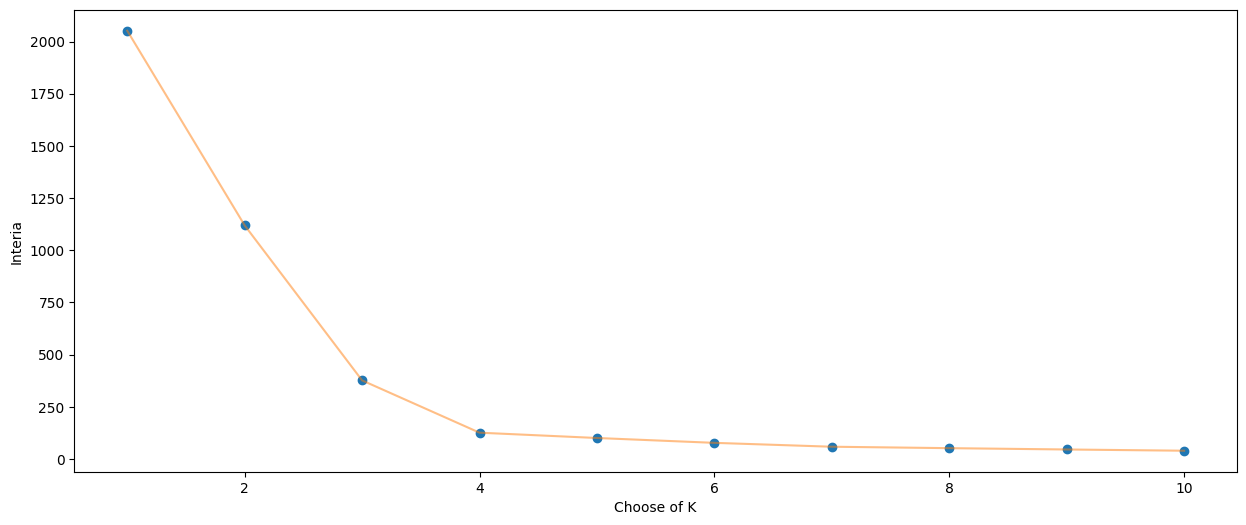

In [33]:
from sklearn.cluster import KMeans
X = scores[index_user].detach().numpy()
df_empty = pd.DataFrame(columns=['first','second','third','label'])
df_empty['first'] = X[:,0]
df_empty['second'] = X[:,1]
df_empty['third'] = X[:,2]
df1 = df_empty[['first','second','third']].iloc[:,:].values  
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(df1)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [34]:
estimators = KMeans(n_clusters=4)
estimators.fit(X)
labele = estimators.labels_
df_empty['label'] = labele

Cluster: 0 0.3294217884540558 0.33662527799606323 0.33395645022392273


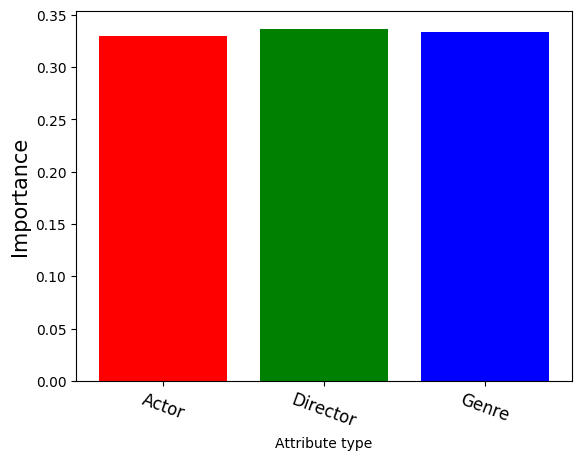

Cluster: 1 0.04552711173892021 0.039278656244277954 0.9151946902275085


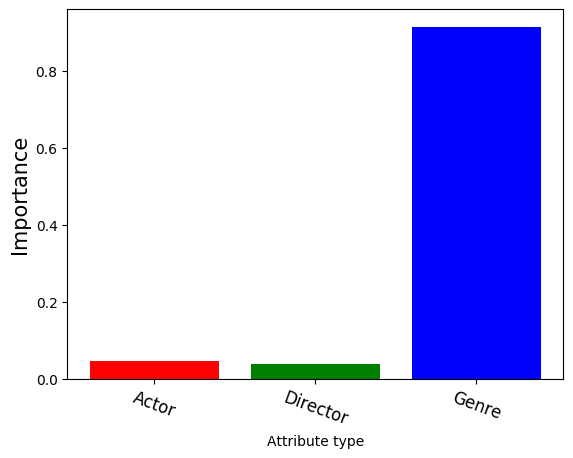

Cluster: 2 0.04057791456580162 0.925457239151001 0.03396519273519516


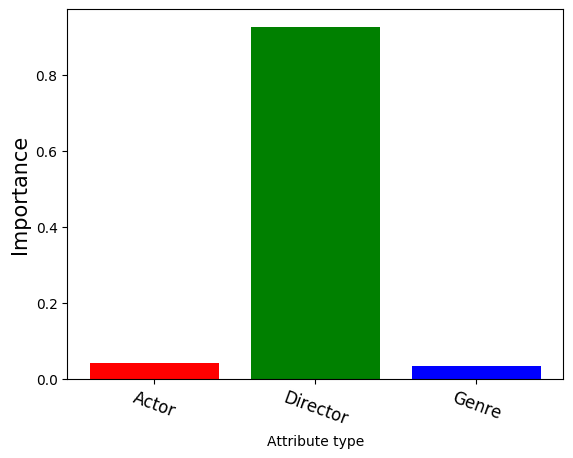

Cluster: 3 0.9030815362930298 0.05096016451716423 0.04595893621444702


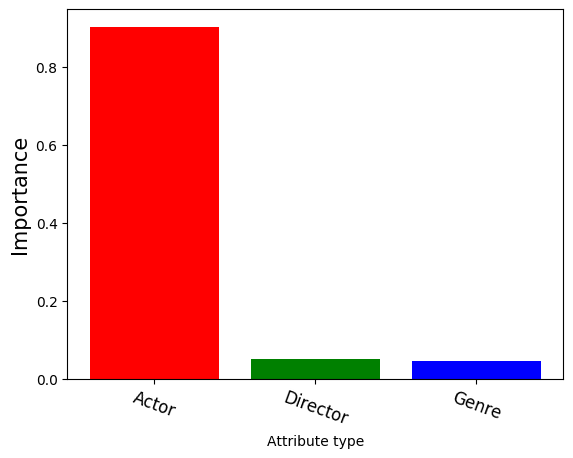

In [35]:
for i in range(4):
    print("Cluster:", i, df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean())
    import matplotlib.pyplot as plt
    plt.xlabel('Attribute type')
    plt.ylabel('Importance',fontsize=15)
    name_list = ['Actor', 'Director','Genre']
    num_list = [df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean()]

    hist_fig = plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
    plt.xticks(fontsize  = 'large',rotation=-20) 
    #plt.savefig('/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/test2.png')

    plt.show()


In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 38616, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

result = ts.fit_transform(data)

# x_min, x_max = np.min(result, 0), np.max(result, 0)
# result = (result - x_min) / (x_max - x_min)

Starting compute t-SNE Embedding...


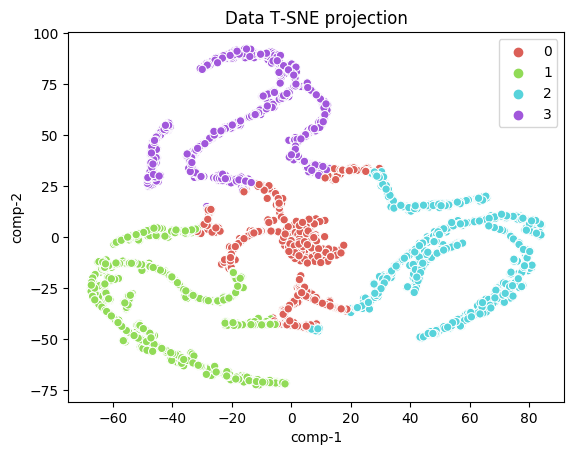

In [37]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Data T-SNE projection")
plt.show()

In [ ]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
from umap import UMAP
import umap.umap_ as umap
import umap.plot
import umap

In [ ]:
reslut = UMAP().fit_transform(X)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)

In [ ]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = reslut[:,0]
df["comp-2"] = reslut[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.show()

In [7]:
from surprise import SVD,KNNBaseline,KNNWithZScore, NMF, SlopeOne, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_sum[['user_id', 'movie', 'user_rating']], reader)


trainset, testset = train_test_split(data, test_size=0.2)

In [12]:
import torch
loss_func = torch.nn.MSELoss()
import numpy as np
for alg in [SVD]:
    real = []
    pre = []
    algo = alg()
    algo.fit(trainset)
    predictions = algo.test(testset)
    for uid, iid, true_r, est, _ in predictions:
        real.append(true_r)
        pre.append(est)
    real = torch.from_numpy(np.array(real))
    pre = torch.from_numpy(np.array(pre))
    rmse = loss_func(pre, real)
    mae = torch.nn.L1Loss()(pre, real)
#     #p, r, f = binary_predictions(real, pre)
#     accuracy = arg_accuracy_int(real, pre)
    print("Results for {}".format(algo))
#     print("Accuracy:", accuracy, "Precision: ", p, "Recall: ", r, "F1 score:", f)
    print("rmse:", rmse, "mae: ",mae)

Results for <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fca014202e0>
rmse: tensor(0.7284, dtype=torch.float64) mae:  tensor(0.6627, dtype=torch.float64)


In [16]:
import pandas as pd
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
def traite_train_test(df):
    df['actors'] = df['actors'].apply(lambda x: json.loads(x))
    df['director'] = df['director'].apply(lambda x: json.loads(x))
    df['genre'] = df['genre'].apply(lambda x: json.loads(x))
    return df
trainset = traite_train_test(trainset)
testset = traite_train_test(testset)

In [78]:
from surprise import SVD,KNNBaseline,KNNWithZScore, NMF, SlopeOne, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
train = Dataset.load_from_df(trainset[['user_id', 'movie', 'user_rating']], reader)
test = Dataset.load_from_df(testset[['user_id', 'movie', 'user_rating']], reader)
train = train.build_full_trainset()
test = test.build_full_trainset()
test = test.build_testset()

In [77]:
algo = SVD()
algo.fit(train)
predictions = algo.test(test)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.7178
MAE:  0.5606


0.5605879847459133

In [19]:
frames = [trainset,testset]
df_sum = pd.concat(frames)

In [20]:
movie_set = set(df_sum['movie'])
movie = df_sum[['movie','actors','director','genre']].loc[df_sum[['movie','actors','director','genre']].astype(str).drop_duplicates().index]
movie.index = range(len(movie))
movie = movie[['movie','actors','director','genre']].loc[movie[['movie','actors','director','genre']].astype(str).drop_duplicates().index]

3.5416666666666665

In [94]:
test_set = {}
for user,pos_item_set in user_item.items():
    if user not in user_item_neg:
        test_set[user] = set()
    mean_rating = df_sum[df_sum['user_id'] == user]['user_rating'].mean()
    user_df = df_sum[df_sum['user_id'] == user]
    neg_df = user_df[user_df['user_rating'] < mean_rating]
    test_set[user] = set(neg_df['movie'])

In [85]:
user_item = {}
user_item_neg = {}
for row in df_sum[df_sum['user_rating'] >=4].itertuples():
    user = getattr(row,'user_id')
    item = getattr(row,'movie')
    if user not in user_item:
        user_item[user] = set()
    user_item[user].add(item)
for user,pos_item_set in user_item.items():
    unwatched_set = movie_set - pos_item_set
    if user not in user_item_neg:
        user_item_neg[user] = set()
    user_item_neg[user] = set(np.random.choice(list(unwatched_set), size=100, replace=False))
    

In [86]:
def dic_order_value_and_get_key(dicts, count):
    final_result = []
    sorted_dic = sorted([(k, v) for k, v in dicts.items()], reverse=True)
    tmp_set = set()
    for item in sorted_dic:
        tmp_set.add(item[1])
    for list_item in sorted(tmp_set, reverse=True)[:count]:
        for dic_item in sorted_dic:
            if dic_item[1] == list_item:
                final_result.append(dic_item[0])
    return final_result

In [87]:
num_i = 100
def get_prediction_list(model,user, target,k):
    user1 = user
    item_neg = user_item_neg[user1]
    movie_rec = movie[movie['movie'].isin(item_neg)]
    movie_rec.index = range(1, len(movie_rec)+1)
    user = np.array([user1] * num_i)
    movie_rec['user'] = np.array(user)
    movie_rec['rating'] = 1.0
    movie_rec = movie_rec[['user','movie','rating']]
    movie_rec.loc[0] = np.array([user1, target, 1.0])
    movie_rec1 = Dataset.load_from_df(movie_rec[['user','movie','rating']], reader)
    test = movie_rec1.build_full_trainset()
    test = test.build_testset()
    predictions = model.test(test)
    predictions_list = []
    for uid, iid, true_r, est, _ in predictions:
        predictions_list.append(est)
    prediction_dict = dict(zip(movie_rec['movie'].values, predictions_list))
    top_k = dic_order_value_and_get_key(prediction_dict,k)
    return top_k

In [88]:
# num_i = 100
# user1 = 2826
# target = 468
# item_neg = user_item_neg[user1]
# movie_rec = movie[movie['movie'].isin(item_neg)]
# movie_rec.index = range(1, len(movie_rec)+1)
# user = np.array([user1] * num_i)
# movie_rec['user'] = np.array(user)
# movie_rec['rating'] = 1.0
# movie_rec = movie_rec[['user','movie','rating']]
# movie_rec.loc[0] = np.array([user1, target, 1.0])
# movie_rec1 = Dataset.load_from_df(movie_rec[['user','movie','rating']], reader)
# test = movie_rec1.build_full_trainset()
# test = test.build_testset()
# predictions = algo.test(test)
# predictions_list = []
# for uid, iid, true_r, est, _ in predictions:
#     predictions_list.append(est)
# prediction_dict = dict(zip(movie_rec['movie'].values, predictions_list))
# #top_k = sorted(prediction_dict, reverse=True)[0:10]

# #movie_rec.loc[0] = np.array([target,user1, 1.0])
# # user = torch.LongTensor(user).to(DEVICE)


# # prediction, scores, contribute_actors, contribute_directors, contribute_genres, cnm = model(
# #     user, actors_id, directors_id, genres_id)
# # prediction = prediction.detach().numpy()
# # prediction_dict = dict(zip(movie_rec['movie'].values, prediction))
# # top_k = sorted(prediction_dict, reverse=True)[0:k]

In [89]:
test_eva = testset[testset['user_rating'] >=4]

In [90]:
import math
def hr_ndcg(data,model):
    hr1 = 0.0
    ndcg1 = 0.0
    hr2 = 0.0
    ndcg2 = 0.0
    test_eva_dict = test_eva.to_dict('records')
    for row in test_eva_dict[:]:
        user = row['user_id']
        target = row['movie']
        
        
        
        recommended_item_10 = get_prediction_list(model,user,target,10)
        recommended_item_20 = get_prediction_list(model,user,target,20)
        if target in recommended_item_10:
            hr1 +=1
            posi = recommended_item_10.index(target)
            ndcg1 += 1 / math.log(posi + 2,2)
        if target in recommended_item_20:
            hr2 +=1
            posi = recommended_item_20.index(target)
            ndcg2 += 1 / math.log(posi + 2,2)
    return hr1 / data.shape[0], ndcg1 / data.shape[0],hr2 / data.shape[0], ndcg2 / data.shape[0]
        